#  Clasificador imagenes de rayos x de pacientes con Neumonía mediante Deep Learning 

Integrantes: 


*   Julio Emmanuel Meza Rangel
*   Carlos Rendón Hernández
*   Rafael Alejandro García Ramírez



El presente trabajo es un modelo de red neuronal convolucional profundo que mediante los datos públicos obtenidos de Mendeley Data [3] que consisten en radiagrafías tomadas a infantes de entre 1 y 5 años de edad quienes acudieron al centro médico para mujeres y niños de Guangzhou en China, como parte de una revisión médica habitual. 

Las imágenes se dividen en tres datasets, uno de entrenamiento, uno de prueba y uno de validación; cada uno con las imágenes clasificadas como 'Normal' para los pacientes sanos y 'Pneumonia' para los pacientes positivos a neumonía. Esta clasificación fue realizada por dos expertos del hospital de Guangzhou. 

Dentro de este proyecto se realiza una red convolucional profunda para la clasificación. Se utilizó para la construcción la paquetería de *tensorflow* y *keras* con kernels cuyos parámetro se ajustan con el entrenamiento del modelo. Esto nos permite un mejor entrenamiento al no tener que realizar una capa por cada elemento de la imagen (dígase lineas verticales, horizontales o formas en específico), esto es de gran ayuda pues dentro de las imágenes no se puede percibir una forma en concreto a identificar dentro de aquellas positivas. 

El proceso de diagnóstico de la neumonía consiste en realizar una radiografía del tórax donde un experto analiza si existe inflamación en los pulmones, posteriormente se realiza un análisis de sangre para determinar si el sistema inmunitario se encuetra luchando contra una infección. Este método muy habitualmente permite un diagnóstico relativamente más rápido que otros métodos, siento que es casi inmediato de no ser por la necesidad de que un especialista determine las condiciones; es por ello del posible interés de acotar este paso para su rápido diagnóstico.


El dataset utilizado para este proyecto se puede encontrar tanto en la pagina de Mendeley Data en el artículo [Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification](https://data.mendeley.com/datasets/rscbjbr9sj/2) o también dentro de la plataforma Kaggle dentro de la publicación [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

Comenzaremos descargando el dataset de kaggle






In [1]:
# instalamos el paquete jovian para extraer los datos de kaggle
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 1.3 MB/s 


In [2]:
# importamos jovian
import jovian 

In [3]:
# creamos la ruta para almacenar los datos
! mkdir ~/.kaggle

In [10]:
# abrimos el API de kaggle 
! cp kaggle.json ~/.kaggle/

In [11]:
# ejecutamos el API
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
# descargamos el dataset 
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:15<00:00, 181MB/s]
100% 2.29G/2.29G [00:15<00:00, 159MB/s]


In [14]:
import os 
import datetime

import numpy as np

import matplotlib.pyplot as plt 

import tensorflow as tf 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout

from keras.preprocessing.image import ImageDataGenerator # para el data augementation

plt.style.use('tableau-colorblind10') # elegimos el estilo de las gráficas

In [15]:
os.listdir() # lista de datos actual 

['.config',
 'kaggle.json',
 'chest-xray-pneumonia.zip',
 'chest_xray',
 'sample_data']

In [16]:
# establecemos la ruta de los archivos 
current = os.getcwd()
path = 'chest_xray'
data = os.path.join(current, path)
os.listdir(data) 

['val', 'train', '__MACOSX', 'chest_xray', 'test']

In [17]:
# establecemos la ruta de los datos 
test_path = os.path.join(data, 'test')
train_path = os.path.join(data, 'train')
val_path = os.path.join(data, 'val')

Comenzaremos explorando la cantidad de imágenes que tenemos para cada sección

In [18]:
# creamos un diccionario con los tamaños de las bases de datos 
data_sizes = { 'test_normal' : len(os.listdir(os.path.join(test_path, 'NORMAL'))), 
    'test_pneumonia' :len(os.listdir(os.path.join(test_path, 'PNEUMONIA'))), 
    'val_normal' :len(os.listdir(os.path.join(val_path, 'NORMAL'))) , 
    'val_pneumonia' : len(os.listdir(os.path.join(val_path, 'PNEUMONIA'))), 
    'train_normal' : len(os.listdir(os.path.join(train_path, 'NORMAL'))), 
    'train_pneumonia' : len(os.listdir(os.path.join(train_path, 'PNEUMONIA'))) }


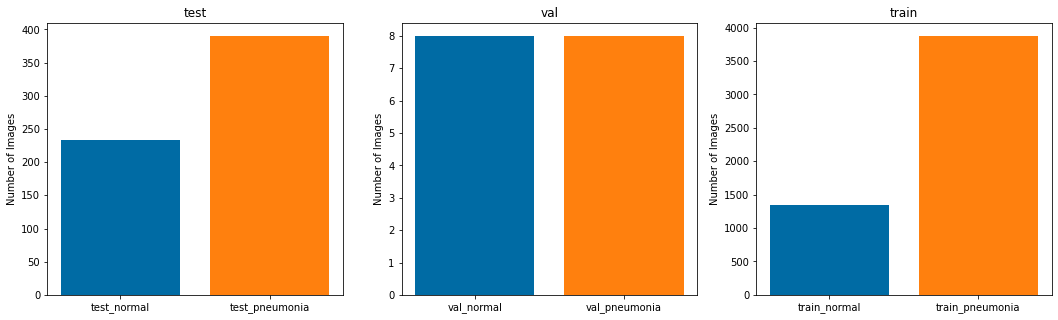

In [19]:
# generador de gráficas para visualización de los datos
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
index = 0
for i in data_sizes: 
    if 'normal' in i: 
        ax[index].bar(i, data_sizes[i], label = 'Normal')
    else: 
        ax[index].bar(i, data_sizes[i], label = 'Pneumonia')
        ax[index].set_ylabel('Number of Images')
        ax[index].set_title(i.split('_')[0])
        index += 1

Notamos que existe una mayor cantidad de imágenes con pneumonia para *test* y *train*.  Y solamente tenemos alrededor de ~5500 imagenes para el *train*, de las cuales, tal y como para el *test*, existe una cantidad mucho mayor para imágenes con neumonía, por lo que vamos a generar imágenes nuevas con diferentcias, tales como rotaciones y demás. Una mayor cantidad de imágenes reducirá la diferencia entre ambas partes al momento de entrenar el modelo. 

Este proceso se llama *Data Augmentation* y ayuda a reducir el overfitting, también para ello usaremos el *dropout* (que aumenta el accuracy un 1-2% que reduce el error rate un 40%, para CNN se usa un $p=[0.4,0.5]$). 

Vemos que tan esparcidos están las dimensiones de las imágenes para decidir que tamaño elegir de reducción de imágen. Dentro del artículo de Sabottke y Spieler (2020) se encuentra que la resolución óptima se encuentra entre $256\times256$ y $448\times 448$. Sin embargo, desconocemos la cantidad de imagenes con una resolución dada y si éstas se encuentran aconglomeradas sobre una zona, requerimos esta información para saber si al establecer esta resolución se hará un Downscaling o un Upscaling. 

Realizamos un histograma con los datos de los tamaños para averiguar que proceso sea mejor, pues un aumento de datos implicaría copiar datos ya existentes posiblemente llevando a un overfitting.

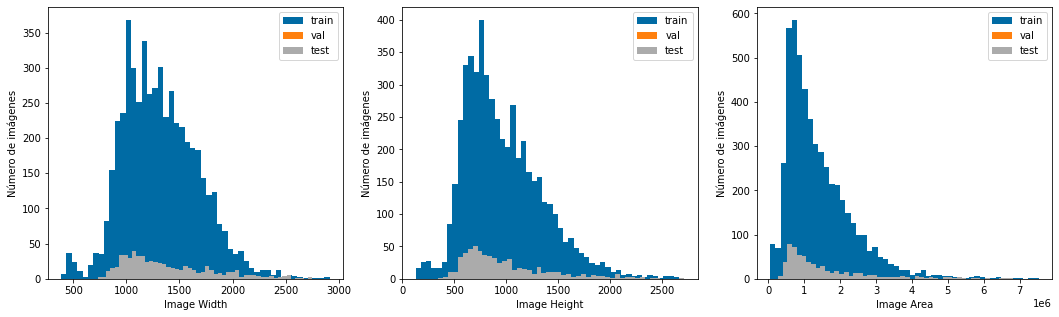

In [20]:
# escogemos PIL dado que es más rápido que imread de matplotlib
from PIL import Image 

def get_image_size(path):
    sizes = []
    for image in os.listdir(path):
        img = Image.open(os.path.join(path, image))
        sizes.append(img.size)
    return sizes

train_sizes = get_image_size(os.path.join(train_path, 'NORMAL'))
train_sizes.extend(get_image_size(os.path.join(train_path, 'PNEUMONIA')))
train_sizes = np.array(train_sizes)

val_sizes = get_image_size(os.path.join(val_path, 'NORMAL'))
val_sizes.extend(get_image_size(os.path.join(val_path, 'PNEUMONIA')))
val_sizes = np.array(val_sizes)

test_sizes = get_image_size(os.path.join(test_path, 'NORMAL'))
test_sizes.extend(get_image_size(os.path.join(test_path, 'PNEUMONIA')))
test_sizes = np.array(test_sizes)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].hist(train_sizes[:, 0], bins=50, label='train')
ax[0].hist(val_sizes[:, 0], bins=50, label='val')
ax[0].hist(test_sizes[:, 0], bins=50, label='test')
ax[0].set_xlabel('Image Width')
ax[0].set_ylabel('Número de imágenes')
ax[0].legend()

ax[1].hist(train_sizes[:, 1], bins=50, label='train')
ax[1].hist(val_sizes[:, 1], bins=50, label='val')
ax[1].hist(test_sizes[:, 1], bins=50, label='test')
ax[1].set_xlabel('Image Height')
ax[1].set_ylabel('Número de imágenes')
ax[1].legend()

ax[2].hist(train_sizes[:, 0] * train_sizes[:, 1], bins=50, label='train')
ax[2].hist(val_sizes[:, 0] * val_sizes[:, 1], bins=50, label='val')
ax[2].hist(test_sizes[:, 0] * test_sizes[:, 1], bins=50, label='test')
ax[2].set_xlabel('Image Area')
ax[2].set_ylabel('Número de imágenes')
ax[2].legend()

plt.show()

Vemos que la resolución de las imágenes en general es buena y de alta calidad, por lo que una reducción de datos significaría retirar valores y quedarnos con una parte de ellos. Suponiendo que no existe una diferencia específica puntual en las imágenes, tales como diferencias minúsculas del orden de unos cuántos pixeles, y tomando en cuenta Sabottke y Spieler (2020), establecemos el tamaño de reducción en un $128\times 128$. 

A continuación, primero vamos a crear los dataset para cada sección y después vamos a hacer el *Data Augmentation* .

In [21]:
image_size = (128,128)
# para train
data_train = tf.keras.utils.image_dataset_from_directory(train_path, color_mode ='grayscale', image_size = image_size) 
data_train = data_train.map(lambda x, y: (tf.cast(x, tf.float32), y)) 
data_train_iterator = data_train.as_numpy_iterator()
batch_data_train = data_train_iterator.next()

# para val 
data_val = tf.keras.utils.image_dataset_from_directory(val_path,color_mode ='grayscale', image_size = image_size)
data_val = data_val.map(lambda x, y: (tf.cast(x, tf.float32), y)) 
data_val_iterator = data_val.as_numpy_iterator()
batch_data_val = data_val_iterator.next()

# para test 
data_test = tf.keras.utils.image_dataset_from_directory(test_path, color_mode ='grayscale', image_size = image_size)
data_test = data_test.map(lambda x, y: (tf.cast(x, tf.float32), y))
data_test_iterator = data_test.as_numpy_iterator()
batch_data_test = data_test_iterator.next()

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


Vemos algunas imágenes al azar (vemos que las etiquetas son {'Normal': 0,'Pneumonia': 1 }), pero primero exploremos la dimensión del tensor de imágen

In [ ]:
# revisamos el .shape
batch_data_train[0][29].shape 

(128, 128, 1)

Notamos que necesitamos realizar un np.squeeze para que los datos $\mathbb{R}^{3}→\mathbb{R}^{2}$, realizando esta conversión y graficando tenemos.

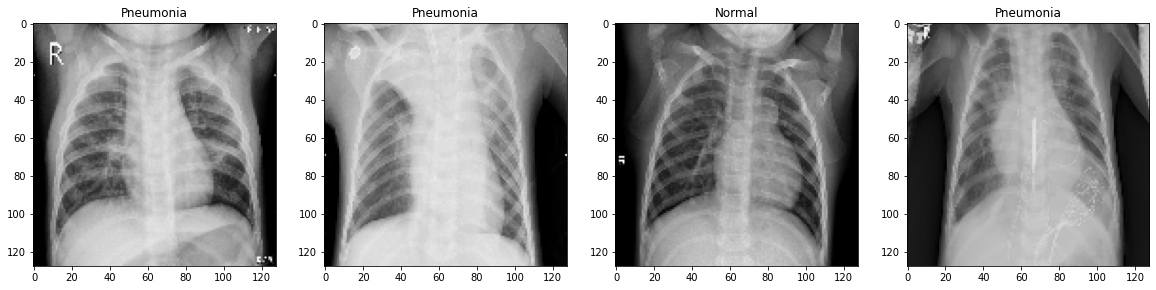

In [25]:
random = np.random.randint(0, len(batch_data_train[0]), 4)
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(0,4): 
    batch_data = np.squeeze(batch_data_train[0][random[i]]) 
    ax[i].imshow(batch_data.astype(int), cmap = 'gray') # astype necesario 
    ax[i].set_title('Pneumonia' if str(batch_data_train[1][random[i]]) == '1' else 'Normal')

Notamos que las imagenes con Pneumonia se encuentra un poco más más borrosas y "nubladas" que las Normales. A pesar de esto la diferencia podría no parecer tan clara a primera vista y mucho menos para alguien que no conoce el dataset. 

Realizamos el data augmentation, para el cual hemos decidido a realizar un escalamiento de $1/255$ que se puede considerar una normalización, una roatción de 20 grados, un cambio de ancho y alto de 0.2, se invertió verticalmente y se llenó el espacio en vació debido a estos cambios con los datos más cercanos.

Se evitó invertir la imagen horizontalmente, pues esto indicaría una imagen de rayos x de un paciente de cabeza, lo cuál no es una situación realista o común. 

Procedemos a crear el generador

In [26]:
# creamos la función para el augmentarion del data 

data_augmentation = ImageDataGenerator(
    rescale = 1./255, # rescalamos los datos 
    rotation_range=20, # rotación de 20 grados
    width_shift_range=0.2, # movemos 0.2 veces la imagen horizontalmente 
    height_shift_range=0.2, # movemos 0.2 veces la imagen verticalmente 
    horizontal_flip=True, # puede haber diferentes distribuciones entre el pulmón izquierdo y derecho
    vertical_flip=False, # no tiene sentido una imagen x-ray de pulmones de cabeza 
    zoom_range=0.2, # hacemos un zoom in de 0.2 
    fill_mode='nearest' # rellenamos los nuevos pixeles con los pixeles más cercanos 
)

In [27]:
# hacemos los augmentation para cada train, test y val 
data_aug_train = data_augmentation.flow_from_directory(train_path, target_size=image_size, batch_size=32, class_mode='categorical')
data_aug_val = data_augmentation.flow_from_directory(val_path, target_size=image_size, batch_size=32, class_mode='binary')
data_aug_test = data_augmentation.flow_from_directory(test_path, target_size=image_size, batch_size=32, class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# revisamos la dimensión del tensor 
data_aug_train[0][0].shape 

(32, 128, 128, 3)

In [ ]:
# revisamos el tipo de dato del tensor 
type(data_aug_val[0])

tuple

In [ ]:
# revisamos que los índices sean los mismos para su clasificación 
print(f'Los classes para train son: {data_aug_train.class_indices}')
print(f'Los classes para test son: {data_aug_test.class_indices}')
print(f'Los classes para val son: {data_aug_val.class_indices}')

Los classes para train son: {'NORMAL': 0, 'PNEUMONIA': 1}
Los classes para test son: {'NORMAL': 0, 'PNEUMONIA': 1}
Los classes para val son: {'NORMAL': 0, 'PNEUMONIA': 1}


Vemos que los índices coinciden. Impirmimos algunas imagenes para revisar algunas modificaciones al azar 

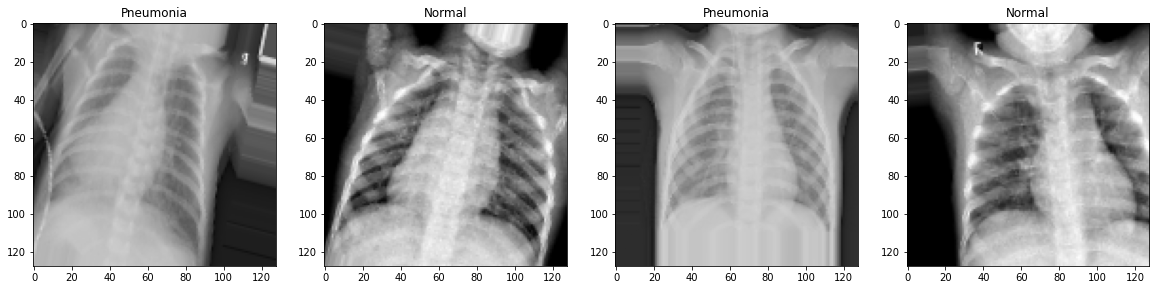

In [ ]:
random = np.random.randint(0, len(data_aug_train[0][0]), 4)
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(0,4): 
    ax[i].imshow(data_aug_train[0][0][random[i]]) 
    ax[i].set_title('Pneumonia' if str(data_aug_train[0][1][random[i]]) == '[0. 1.]' else 'Normal')

Creamos el modelo con la siguiente arquitectura, el cuál es una modificación de la arquitectura utilizada por Anjana Tiha (cuyo sitio web puede acceder con el siguiente enlace [anjanatiha.wixsite](https://anjanatiha.wixsite.com/website) y su correo de contacto ese anjana.tiha@gmail.com)

In [28]:
# MIT License

# Copyright (c) 2018 Anjana Tiha

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def pneumonia_model_test():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(128,128,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(128,128,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model


In [29]:
# establecemos el modelo 
model = pneumonia_model_test()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                        

In [30]:
# compilamos el modelo  con un optimizamdor 'adam' 
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Finalmente, entrenamos el modelo con $20$ epochs

In [31]:
hist = model.fit(data_aug_train, epochs=20)

Epoch 1/20
163/163 [==============================] - 373s 2s/step - loss: 0.3207 - accuracy: 0.8623
Epoch 2/20
163/163 [==============================] - 371s 2s/step - loss: 0.2076 - accuracy: 0.9139
Epoch 3/20
163/163 [==============================] - 372s 2s/step - loss: 0.1926 - accuracy: 0.9321
Epoch 4/20
163/163 [==============================] - 374s 2s/step - loss: 0.1604 - accuracy: 0.9390
Epoch 5/20
163/163 [==============================] - 373s 2s/step - loss: 0.1546 - accuracy: 0.9438
Epoch 6/20
163/163 [==============================] - 372s 2s/step - loss: 0.1556 - accuracy: 0.9457
Epoch 7/20
163/163 [==============================] - 370s 2s/step - loss: 0.1501 - accuracy: 0.9454
Epoch 8/20
163/163 [==============================] - 368s 2s/step - loss: 0.1430 - accuracy: 0.9488
Epoch 9/20
163/163 [==============================] - 376s 2s/step - loss: 0.1305 - accuracy: 0.9523
Epoch 10/20
163/163 [==============================] - 371s 2s/step - loss: 0.1237 - accura

Evaluamos el modelo con los datos de prueba

In [45]:
stats = model.evaluate(data_aug_test, verbose = 0)
print(f'La precisión del modelo es {stats[1]*100:.2f}% con un loss de {stats[0]:.2f}.')

La precisión del modelo es 83.81% con un loss de 0.38.


Creamos una matriz de confusión para evaluar los casos, asímismo como un reporte de clasificación, performance del modelo y una curva característica operativa de receptor (ROC).

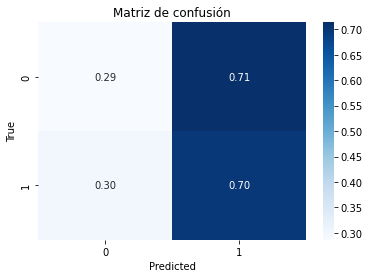

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns   

y_pred = model.predict(data_aug_test, verbose = 0)
y_pred = np.argmax(y_pred, axis=1)
y_true = data_aug_test.classes

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [47]:
# hacemos un reporte de clasificación 
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia']))


              precision    recall  f1-score   support

      Normal       0.36      0.29      0.32       234
   Pneumonia       0.62      0.70      0.66       390

    accuracy                           0.54       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.54      0.53       624



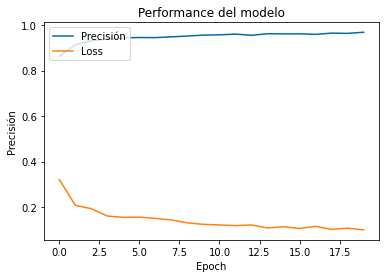

In [48]:
# graficamos el performance del modelo 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.title('Performance del modelo')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(['Precisión', 'Loss'], loc='upper left')
plt.show()

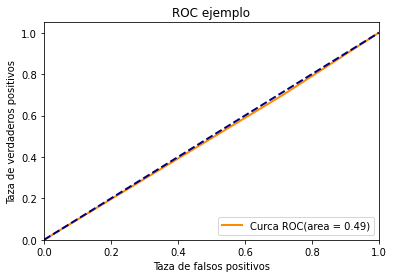

In [49]:
# hacemos una curva ROC (curva Característica operativa de receptor)
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='Curca ROC(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taza de falsos positivos')
plt.ylabel('Taza de verdaderos positivos')
plt.title('ROC ejemplo')
plt.legend(loc="lower right")
plt.show()

Realizamos una prueba con las imágenes que nos quedan en el set de validación. Aquellas imagenes con el título en verde son aquellas predichas con éxito y aquellas con título rojo aquellas que no.

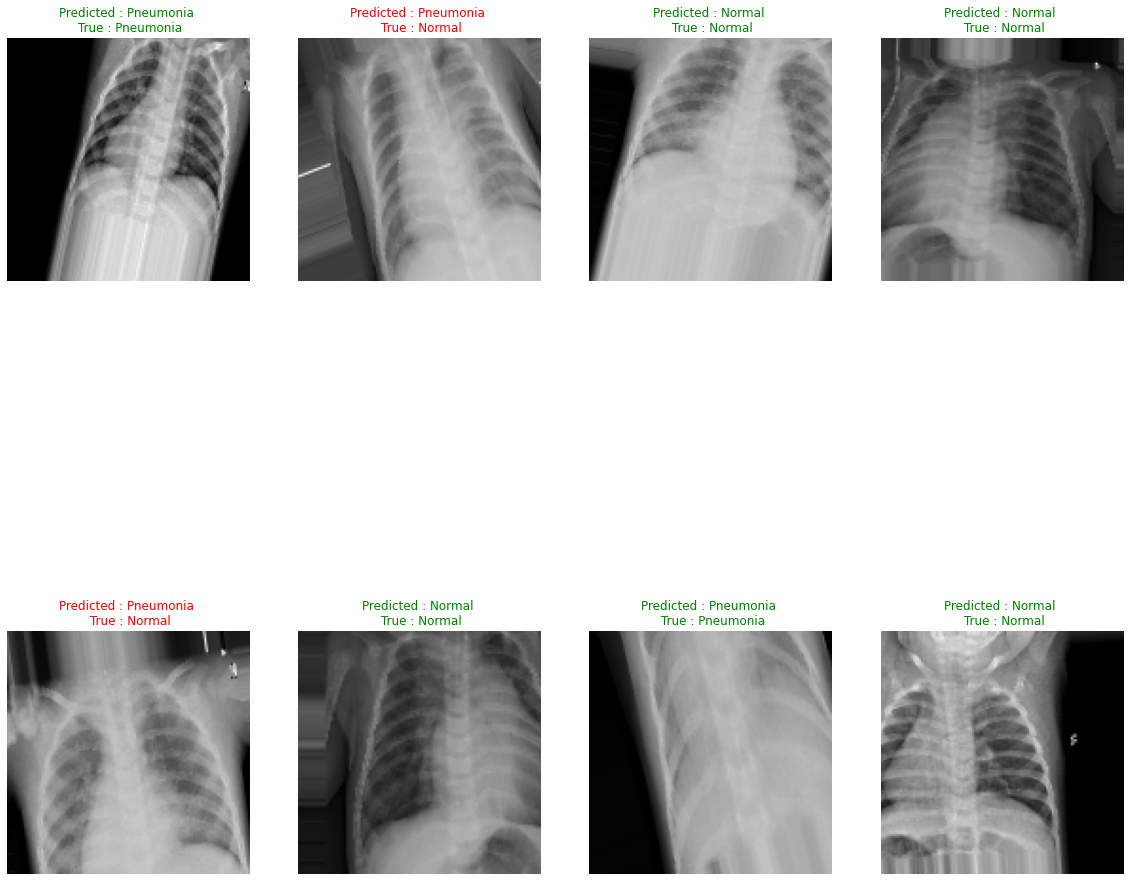

In [73]:
fig, ax = plt.subplots(2, 4, figsize=(20, 20))
for i in range(0,2):
  for j in range(0,4):
    predicted_tag = model.predict(np.expand_dims(data_aug_val[0][0][i*2+j], axis=0), verbose=0)
    predicted_tag = np.argmax(predicted_tag, axis=1)
    predicted_tag = 'Pneumonia' if predicted_tag[0] == 1 else 'Normal'
    true_tag = 'Pneumonia' if str(data_aug_val[0][1][i*2+j]) == '1.0' else 'Normal'
    ax[i][j].set_title(f"Predicted : {predicted_tag} \n True : {true_tag}", color = 'green' if predicted_tag == true_tag else 'red')
    ax[i][j].imshow(data_aug_train[0][0][i*2+j]) 
    ax[i][j].margins(x=0)
    ax[i][j].axis('off')

# Referencias Bibliográficas 


1.	Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".
2.	Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C. C., Liang, H., Baxter, S. L., ... & Zhang, K. (2018). Identifying medical diagnoses and treatable diseases by image-based deep learning. Cell, 172(5), 1122-1131.
3.	Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2
4.	Sabottke, C. F., & Spieler, B. M. (2020). The effect of image resolution on deep learning in radiography. Radiology. Artificial intelligence, 2(1).


